<h3><center><strong>COSC 4368 - Artificial Intelligence - Spring 2024</strong></center>
<center><strong>Group Project: Path Discovery in a 3-Agent Transportation World Using Reinforcement Learning</strong></center><h3>
<h4><center>Roberto Jackson Baeza [1861128]<br>
Jusvin Charles [2105957]<br>
Stephany Lopez [2142613]<br>
Radhika Sonde [1964766]</center></h4>

In [2]:
# System dependencies
import numpy as np
import random
import matplotlib.pyplot as plt

##### QTable Class: 
The Q-table class uses a constructor that initializes the Q-table with zeros based on the size of the environment and learning parameters. The function get_q_value retrieves the Q-value for a given position-action pair, while update_q_value updates it using the Bellman equation considering the immediate reward and the next position. The print_q_table function displays the Q-table in a readable format, organizing Q-values for each state-action pair. The select_action function chooses an action according to specified policies: randomly from legal moves, with a probability-based exploitation of Q-values, or greedily exploiting Q-values.

Parameters definitions within QTable class:

* environment_rows: The number of rows in the environment grid.
* environment_cols: The number of columns in the environment grid.
* num_actions: The number of possible actions an agent can take.
* learning_rate: The learning rate used to update Q-values.
* discount_factor: The discount factor used to balance immediate and future rewards.
* q_table: A 3D NumPy array storing the Q-values for each state-action pair in the environment.

Parameters definitions within functions:

* position: A tuple representing the current position (row and column coordinates) of the agent in the environment.
* action: An integer representing the action taken by the agent.
* reward: The immediate reward received by the agent for taking an action.
* next_position: A tuple representing the next position (row and column coordinates) of the agent after taking an action.
* policy: A string representing the policy used for action selection.
* legal_moves: A list of strings representing the legal moves available to the agent from the current position.

In [3]:
# QTable Class and related functions for reinforcement learning
class QTable:
    def __init__(self, environment_rows, environment_cols, num_actions, learning_rate, discount_factor):
        # Initialize QTable with environment parameters and zero-initialized Q-values
        self.environment_rows = environment_rows
        self.environment_cols = environment_cols
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((environment_rows, environment_cols, num_actions))

    # Set Q value for a specific position-action pair
    def set_q_value(self, position, action, new_q_value):
        action_index = self.get_action_index(action)
        self.q_table[position[0] - 2, (position[1] - 1), action_index] = new_q_value

    # Retrieve Q-value for a given position-action pair
    def get_q_value(self, position, action):
        action_index = self.get_action_index(action)
        iposition = position[0] - 1
        jposition = position[1] - 1
        return self.q_table[iposition, jposition, action_index]

    # Calculate Q value based on the learning method (Q-learning or SARSA)
    def calc_q_value(self, position, action, reward, next_position, next_legal_moves, next_step, learning_method):
        if action == "":
            return  # Do nothing if no action
        current_q_value = self.get_q_value(position, action)
        if learning_method == "Q":
            max_next_q_value = -10000
            for move in next_legal_moves:
                curr_next_q_value = self.get_q_value(next_position, move)
                if curr_next_q_value > max_next_q_value:
                    max_next_q_value = curr_next_q_value
            new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (
                    reward + self.discount_factor * max_next_q_value)
            self.set_q_value(position, action, new_q_value)
        if learning_method == "S":
            next_q_value = self.get_q_value(next_position, next_step)
            new_q_value = current_q_value + self.learning_rate * (
                    reward + (self.discount_factor * current_q_value) - next_q_value)
            self.set_q_value(position, action, new_q_value)

    # Print the Q-table in a readable format
    def print_q_table(self):
        print("Q-table:")
        print("State   |     P       D      N      E      S      W")
        print("------------------------------------------------------")
        for row in range(self.environment_rows):
            for col in range(self.environment_cols):
                print(f"({row},{col})   | ", end="")
                for action_idx in range(self.num_actions):
                    q_value_str = f"{self.q_table[row, col, action_idx]:>7.2f}"
                    print(q_value_str, end="")
                print()

    # Select an action based on the specified policy
    def select_action(self, position, policy, legal_moves):
        if len(legal_moves) == 0:
            return ""
        if policy == "PRANDOM":
            return random.choice(legal_moves)
        elif policy == "PEXPLOIT":
            if random.random() < 0.8:
                return self.get_best_move(position, legal_moves)
            else:
                return random.choice(legal_moves)
        elif policy == "PGREEDY":
            return self.get_best_move(position, legal_moves)

    # Get the best move based on Q-values for a given position
    def get_best_move(self, position, legal_moves):
        if "P" in legal_moves:
            return "P"
        if "D" in legal_moves:
            return "D"
        max_q_value = -10000
        best_move = ""
        for move in legal_moves:
            curr_q_value = self.get_q_value(position, move)
            if curr_q_value > max_q_value:
                max_q_value = curr_q_value
                best_move = move
        return best_move

    # Map action to its index
    def get_action_index(self, action):
        if action == "P":
            index = 0
        elif action == "D":
            index = 1
        elif action == "N":
            index = 2
        elif action == "E":
            index = 3
        elif action == "S":
            index = 4
        elif action == "W":
            index = 5
        else:
            print(f"Action: {action}")
        return index

##### Agent Class: 
It represents individual agents within the environment, encapsulating their behavior and learning process.
The state space is a list of the form: [i, j, i’, j’, i’’, j’’, x, x’, x’’, a, b, c, d, e, f] with:
* (i, j, i’, j’, i’’, j’’) representing the positions of the red, blue, and black agents.
* (x, x’, x’’) is 1 if the red, blue, or black agent carries a block and 0 if not.
* (a, b, c, d, e, f) represent the number of blocks in each pick-up and drop-off location.

In [4]:
# Class definition for defining different agents & their functions
class Agent():

    def __init__(self, agentID):
        self.qtable = None              # To be filled out later
        self.agentID = agentID          # Red=0, Blue=1, Black=2    
        self.reward = 0                 # Current rewards scored
        self.rewardList = []            # Rewards scored for each step
        self.nextstep = ""              # Future action for SARSA and Step function   

    # Set reward for pickup
    def setPickupReward(self):
        self.reward += 13

    # Set reward for dropoff
    def setDropoffReward(self):
        self.reward += 13

    # Set penalty for moving
    def setMovePenalty(self):
        self.reward -= 1

    # Append current reward to agent's reward list for each step
    def setRewardList(self, reward):
        self.rewardList.append(reward)

    # Initialize Q-table for the agent
    def setAgentQTable(self, environment_rows, environment_cols, num_actions, learning_rate, discount_factor):
        self.qtable = QTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

    # Set next step for the agent
    def setAgentNextStep(self, nextStep):
        self.nextstep = nextStep

    # Get the agent's next step
    def getAgentNextStep(self):
        return self.nextstep
    
    # Get current rewards for the agent
    def getReward(self):
        return self.reward

    # Get list of rewards for the agent
    def getRewardList(self):
        return self.rewardList
    
    # Get the position of the agent
    def getPosition(self, gamestate):
        agentI = gamestate[self.agentID*2]
        agentJ = gamestate[self.agentID*2+1]
        return [agentI, agentJ]

    # Get the next position of the agent
    def getNextPosition(self, position, nextMove):
        if(nextMove == "N"):
            position[0] = position[0]-1
        if(nextMove == "S"):
            position[0] = position[0]+1
        if(nextMove == "W"):
            position[1] = position[1]-1
        if(nextMove == "E"):
            position[1] = position[1]+1
        return position
    
    # Get legal moves for the agent based on the current game state
    def getLegalMoves(self, gamestate):
        legalMoves = ["P", "D", "N", "S", "E", "W"]  # List of all possible moves
        positions = gamestate[0:6]  # Extract agent and block positions from the game state
        position = self.getPosition(gamestate)  # Get current agent position

        ipositions = [positions[0], positions[2], positions[4]]  # Extract agent row positions
        agentI = ipositions.pop(self.agentID)  # Remove current agent row position

        jpositions = [positions[1], positions[3], positions[5]]  # Extract agent column positions
        agentJ = jpositions.pop(self.agentID)  # Remove current agent column position

        otherAgentPositions = [[ipositions[0], jpositions[0]], [ipositions[1], jpositions[1]]]  # Positions of other agents

        agentBox = gamestate[self.agentID + 6]  # Check if agent is carrying a block

        dropoff = gamestate[9:12]  # Drop-off locations
        dropoffPositions = [[1, 1], [3, 1], [4, 5]]  # Define initial drop-off locations

        pickup = gamestate[12:]  # Pickup locations
        pickupPositions = [[1, 5], [2, 4], [5, 2]]  # Define initial pickup locations

        # Adjust legal moves based on game conditions
        if agentBox == 0:  # If agent is not carrying a block
            legalMoves.remove("D")  # Cannot drop off
            if [agentI, agentJ] not in pickupPositions:  # If agent is not at a pickup location
                legalMoves.remove("P")  # Cannot pick up
            else:
                index = 0
                for location in pickupPositions:
                    if [agentI, agentJ] == location and pickup[index] == 0:
                        legalMoves.remove("P")  # Cannot pick up if a block is not available
                    index += 1
        else:  # If agent is carrying a block
            legalMoves.remove("P")  # Cannot pick up
            if [agentI, agentJ] not in dropoffPositions:  # If agent is not at a drop-off location
                legalMoves.remove("D")  # Cannot drop off
            else:
                index = 0
                for location in dropoffPositions:
                    if [agentI, agentJ] == location and dropoff[index] == 5:
                        legalMoves.remove("D")  # Cannot drop off if drop-off location is full
                    index += 1

        # Adjust legal moves based on adjacent agents and boundaries
        if [agentI - 1, agentJ] in otherAgentPositions or agentI - 1 == 0:
            legalMoves.remove("N")  # Remove North move
        if [agentI + 1, agentJ] in otherAgentPositions or agentI + 1 == 6:
            legalMoves.remove("S")  # Remove South move
        if [agentI, agentJ - 1] in otherAgentPositions or agentJ - 1 == 0:
            legalMoves.remove("W")  # Remove West move
        if [agentI, agentJ + 1] in otherAgentPositions or agentJ + 1 == 6:
            legalMoves.remove("E")  # Remove East move

        return legalMoves

    # Get legal moves for the agent considering pickup locations for Experiment 4
    def getLegalMoves4(self, gamestate):
        legalMoves = ["P", "D", "N", "S", "E", "W"]  # List of all possible moves
        positions = gamestate[0:6]  # Extract agent and block positions from the game state
        position = self.getPosition(gamestate)  # Get current agent position

        ipositions = [positions[0], positions[2], positions[4]]  # Extract agent row positions
        agentI = ipositions.pop(self.agentID)  # Remove current agent row position

        jpositions = [positions[1], positions[3], positions[5]]  # Extract agent column positions
        agentJ = jpositions.pop(self.agentID)  # Remove current agent column position

        otherAgentPositions = [[ipositions[0], jpositions[0]], [ipositions[1], jpositions[1]]]  # Positions of other agents

        agentBox = gamestate[self.agentID + 6]  # Check if agent is carrying a block

        dropoff = gamestate[9:12]  # Drop-off locations
        dropoffPositions = [[1, 1], [3, 1], [4, 5]]  # Define initial drop-off locations

        pickup = gamestate[12:]  # Pickup locations
        pickupPositions = [[4, 2], [3, 3], [2, 4]]  # Define initial pickup locations for Experiment 4

        # Adjust legal moves based on game conditions
        if agentBox == 0:  # If agent is not carrying a block
            legalMoves.remove("D")  # Cannot drop off
            if [agentI, agentJ] not in pickupPositions:  # If agent is not at a pickup location
                legalMoves.remove("P")  # Cannot pick up
            else:
                index = 0
                for location in pickupPositions:
                    if [agentI, agentJ] == location and pickup[index] == 0:
                        legalMoves.remove("P")  # Cannot pick up if a block is not available
                    index += 1
        else:  # If agent is carrying a block
            legalMoves.remove("P")  # Cannot pick up
            if [agentI, agentJ] not in dropoffPositions:  # If agent is not at a drop-off location
                legalMoves.remove("D")  # Cannot drop off
            else:
                index = 0
                for location in dropoffPositions:
                    if [agentI, agentJ] == location and dropoff[index] == 5:
                        legalMoves.remove("D")  # Cannot drop off if drop-off location is full
                    index += 1

        # Adjust legal moves based on adjacent agents and boundaries
        if [agentI - 1, agentJ] in otherAgentPositions or agentI - 1 == 0:
            legalMoves.remove("N")  # Remove North move
        if [agentI + 1, agentJ] in otherAgentPositions or agentI + 1 == 6:
            legalMoves.remove("S")  # Remove South move
        if [agentI, agentJ - 1] in otherAgentPositions or agentJ - 1 == 0:
            legalMoves.remove("W")  # Remove West move
        if [agentI, agentJ + 1] in otherAgentPositions or agentJ + 1 == 6:
            legalMoves.remove("E")  # Remove East move

        return legalMoves
    
    # Get the game state after taking a specific action
    def getGameState(self, gamestate, nextMove):
        agentI = gamestate[self.agentID * 2]  # Current row position of the agent
        agentJ = gamestate[self.agentID * 2 + 1]  # Current column position of the agent

        dropoffPositions = [[1, 1], [3, 1], [4, 5]]  # Drop-off locations
        pickupPositions = [[1, 5], [2, 4], [5, 2]]  # Pickup locations

        # Update game state based on the next move
        if nextMove == "D":  # If the action is to drop off
            index = 0
            for location in dropoffPositions:
                if [agentI, agentJ] == location:
                    gamestate[9 + index] = gamestate[9 + index] + 1  # Increment drop-off count
                index += 1
            gamestate[6 + self.agentID] = 0  # Update agent block status
        elif nextMove == "P":  # If the action is to pick up
            index = 0
            for location in pickupPositions:
                if [agentI, agentJ] == location:
                    gamestate[12 + index] = gamestate[12 + index] - 1  # Decrement pickup count
                index += 1
            gamestate[6 + self.agentID] = 1  # Update agent block status
        elif nextMove == "N":  # If the action is to move North
            gamestate[self.agentID * 2] = agentI - 1  # Update agent row position
        elif nextMove == "S":  # If the action is to move South
            gamestate[self.agentID * 2] = agentI + 1  # Update agent row position
        elif nextMove == "W":  # If the action is to move West
            gamestate[self.agentID * 2 + 1] = agentJ - 1  # Update agent column position
        elif nextMove == "E":  # If the action is to move East
            gamestate[self.agentID * 2 + 1] = agentJ + 1  # Update agent column position

        return gamestate

    # Get the game state after taking a specific action, considering pickup locations for Experiment 4
    def getGameState4(self, gamestate, nextMove):
        agentI = gamestate[self.agentID * 2]  # Current row position of the agent
        agentJ = gamestate[self.agentID * 2 + 1]  # Current column position of the agent

        dropoffPositions = [[1, 1], [3, 1], [4, 5]]  # Drop-off locations
        pickupPositions = [[4, 2], [3, 3], [2, 4]]  # Pickup locations for Experiment 4

        # Update game state based on the next move
        if nextMove == "D":  # If the action is to drop off
            index = 0
            for location in dropoffPositions:
                if [agentI, agentJ] == location:
                    gamestate[9 + index] = gamestate[9 + index] + 1  # Increment drop-off count
                index += 1
            gamestate[6 + self.agentID] = 0  # Update agent block status
        elif nextMove == "P":  # If the action is to pick up
            index = 0
            for location in pickupPositions:
                if [agentI, agentJ] == location:
                    gamestate[12 + index] = gamestate[12 + index] - 1  # Decrement pickup count
                index += 1
            gamestate[6 + self.agentID] = 1  # Update agent block status
        elif nextMove == "N":  # If the action is to move North
            gamestate[self.agentID * 2] = agentI - 1  # Update agent row position
        elif nextMove == "S":  # If the action is to move South
            gamestate[self.agentID * 2] = agentI + 1  # Update agent row position
        elif nextMove == "W":  # If the action is to move West
            gamestate[self.agentID * 2 + 1] = agentJ - 1  # Update agent column position
        elif nextMove == "E":  # If the action is to move East
            gamestate[self.agentID * 2 + 1] = agentJ + 1  # Update agent column position

        return gamestate

    # Step for a single agent using SARSA
    def stepS(self, gamestate, policy):
        learning_method = "S"  # Marking the learning method as SARSA
        
        # Determine the next move for the agent
        next_move = self.getAgentNextStep()
        position = self.getPosition(gamestate)  # Get the current position of the agent
        
        # If no explicit next move is set, choose one based on available legal moves
        if next_move == "":
            legal_moves = self.getLegalMoves(gamestate)
            if "P" in legal_moves:
                next_move = "P"
            elif "D" in legal_moves:
                next_move = "D"
            else:
                next_move = random.choice(legal_moves)
        
        # Update position and gamestate based on the chosen move
        next_position = position
        next_gamestate = self.getGameState(gamestate, next_move)
        next_legal_moves = self.getLegalMoves(next_gamestate)
        
        # Determine the reward and consequences of the chosen move
        if next_move == "P":
            self.setPickupReward()
            turn_reward = 13
        elif next_move == "D":
            self.setDropoffReward()
            turn_reward = 13
        else:
            self.setMovePenalty()
            next_position = self.getNextPosition(position, next_move)
            next_gamestate = self.getGameState(gamestate, next_move)
            next_legal_moves = self.getLegalMoves(next_gamestate)
            turn_reward = -1
        
        # Select the next action using the Q-table and update Q-values
        agent_next_step = self.qtable.select_action(next_position, policy, next_legal_moves)
        self.setAgentNextStep(agent_next_step)
        self.qtable.calc_q_value(position, next_move, turn_reward, next_position, next_legal_moves, agent_next_step, learning_method)
        self.setRewardList(self.getReward())
        
        return next_gamestate

    # Step for a single agent using Q-learning
    def stepQ(self, gamestate, policy):
        learning_method = "Q"  # Marking the learning method as Q-learning
        
        # Get legal moves for the agent
        legal_moves = self.getLegalMoves(gamestate)
        position = self.getPosition(gamestate)
        
        # Select action based on the Q-table and policy, and set agent reward accordingly
        if "P" in legal_moves:
            next_move = "P"
            self.setPickupReward()
            turn_reward = 13
        elif "D" in legal_moves:
            next_move = "D"
            self.setDropoffReward()
            turn_reward = 13
        else: 
            # If neither pickup nor dropoff is available, use Q-table-based policy
            next_move = self.qtable.select_action(position, policy, legal_moves)
            self.setMovePenalty()
            turn_reward = -1
        
        # Update position and gamestate based on the chosen move
        next_position = self.getNextPosition(position, next_move)
        next_gamestate = self.getGameState(gamestate, next_move)
        next_legal_moves = self.getLegalMoves(next_gamestate)
        
        # Update Q-values based on the chosen action and its consequences
        self.qtable.calc_q_value(position, next_move, turn_reward, next_position, next_legal_moves, "NA", learning_method)
        self.setRewardList(self.getReward())
        
        return next_gamestate
    
    # Step for a single agent using Q-learning, considering pickup locations in experiment 4
    def stepQ4(self, gamestate, policy):
        learning_method = "Q"  # Marking the learning method as Q-learning
        
        # Get legal moves for the agent considering pickup locations in experiment 4
        legal_moves = self.getLegalMoves4(gamestate)
        position = self.getPosition(gamestate)
        
        # Select action based on the Q-table and policy, and set agent reward accordingly
        if "P" in legal_moves:
            next_move = "P"
            self.setPickupReward()
            turn_reward = 13
        elif "D" in legal_moves:
            next_move = "D"
            self.setDropoffReward()
            turn_reward = 13
        else: 
            # If neither pickup nor dropoff is available, use Q-table-based policy
            next_move = self.qtable.select_action(position, policy, legal_moves)
            self.setMovePenalty()
            turn_reward = -1
        
        # Update position and gamestate based on the chosen move and considering pickup locations in experiment 4
        next_position = self.getNextPosition(position, next_move)
        next_gamestate = self.getGameState4(gamestate, next_move)
        next_legal_moves = self.getLegalMoves4(next_gamestate)
        
        # Update Q-values based on the chosen action and its consequences
        self.qtable.calc_q_value(position, next_move, turn_reward, next_position, next_legal_moves, "NA", learning_method)
        self.setRewardList(self.getReward())
        
        return next_gamestate
    

In [5]:
# Check if the game has finished by examining the state of dropoff locations
def finishCheck(gamestate):
    if gamestate[9:] == [5, 5, 5, 0, 0, 0]:
        return True  # Return True if all dropoff locations are filled and all pickups are delivered
    return False  # Otherwise, return False

##### Experiment 1: 

In Experiment 1 we use a learning_rate of 0.3, a discount_factor of 0.5, and run Q-learning for 9000 steps; initially we run the policy ‘PRANDOM’ for 500 steps, then:
* a.	We continue running ‘PRANDOM’ for 8500 more steps
* b.	Next we run ‘PGREEDY’ for the remaining 8500 steps
* c.	Finally we run ‘PEXPLOIT’ for the remaining 8500 steps

First Random Run (500 steps): [5, 5, 4, 2, 4, 4, 0, 0, 0, 3, 5, 2, 5, 0, 0]
Red Reward: -54
Blue Reward: -110
Black Reward: -54



Second Run (8500 steps): [2, 5, 4, 4, 3, 1, 1, 0, 0, 0, 0, 0, 5, 4, 5]
Red Reward: -1921
Blue Reward: -2075
Black Reward: -1767

Greedy Run (8500 steps): [2, 3, 4, 3, 2, 4, 0, 0, 1, 0, 0, 0, 5, 4, 5]
Red Reward: -4754
Blue Reward: -4908
Black Reward: -4586

Exploit Run (8500 steps): [2, 3, 1, 2, 4, 3, 1, 1, 1, 5, 5, 2, 0, 0, 0]
Red Reward: -7377
Blue Reward: -7559
Black Reward: -7013

Red Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.66   0.00  -0.76  -1.00
(0,1)   |    0.00   0.00  -0.77  -1.28  -0.92  -1.18
(0,2)   |    0.00   0.00  -0.77  -1.35  -0.93  -1.34
(0,3)   |    3.82   0.00  -0.77  -1.34  -0.93  -1.24
(0,4)   |    0.00   0.00  -0.66  -1.00  -0.76   0.00
(1,0)   |    0.00   3.90  -0.51   0.00  -0.66  -1.00
(1,1)   |    0.00   0.00  -0.55  -1.23  -0.77  -1.14
(1,2)   |    0.00   0.00  -0.55  -1.23  -0.77  -1.22
(1,3)   |    0.00   0.00  -0.55  -1.22  -0.77  -1.23
(

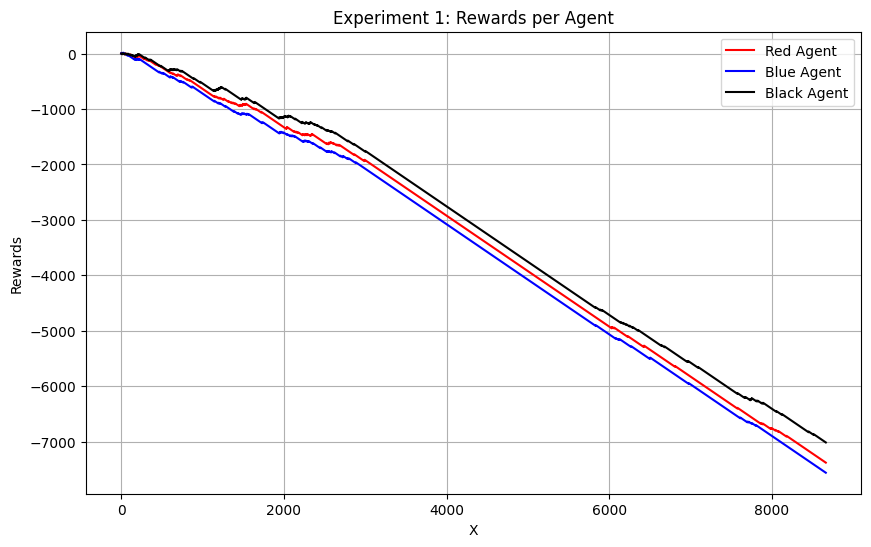

In [105]:
# Experiment 1 - Environment parameters
environment_rows = 5
environment_cols = 5
num_actions = 6
learning_rate = 0.3
discount_factor = 0.5

# Initialize agents with Q-tables
redAgent = Agent(0)
redAgent.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blueAgent = Agent(1)
blueAgent.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blackAgent = Agent(2)
blackAgent.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

# Initial environment states
initialEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
testEnvironment =    [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5]
currEnvironment = initialEnvironment
policy = "PRANDOM"

# Run 500 steps with random policy
first500 = int(500/3)
for i in range(first500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the first run
print(f"First Random Run (500 steps): {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")

# Second Round
currEnvironment = None
currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
random8500 = int(8500/3)
for i in range(random8500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the second run
print(f"\nSecond Run (8500 steps): {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")

# Third Round
currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
greedy8500 = int(8500/3)
policy = "PGREEDY"
for i in range(greedy8500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the greedy run
print(f"\nGreedy Run (8500 steps): {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")

# Fourth Round
currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the exploit run
print(f"\nExploit Run (8500 steps): {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")

# Display Q-tables for each agent
print("\nRed Agent QTable")
redAgent.qtable.print_q_table()
print("\nBlue Agent QTable")
blueAgent.qtable.print_q_table()
print("\nBlack Agent QTable")
blackAgent.qtable.print_q_table()

# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent.getRewardList(), color='red', label='Red Agent')
plt.plot(blueAgent.getRewardList(), color='blue', label='Blue Agent')
plt.plot(blackAgent.getRewardList(), color='black', label='Black Agent')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Rewards')
plt.title('Experiment 1: Rewards per Agent')
plt.legend()
plt.grid(True)
plt.show()

##### Experiment 2: 

Experiment 2 is the same as experiment 1.c except this time we run the SARSA learning algorithm for 9000 steps.


Exploit Run: [3, 3, 3, 1, 3, 1, 0, 0, 0, 2, 3, 0, 0, 5, 5]
Red Reward: -2972
Blue Reward: -2944
Black Reward: -2944

Red Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.30   0.00  -0.30   0.00
(0,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(0,2)   |    0.00   0.00  -0.30   0.00  -0.30   0.00
(0,3)   |    0.00   0.00   0.00   0.00   0.00   0.00
(0,4)   |    0.00   0.00  -0.30   0.00  -0.30   0.00
(1,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,1)   |    0.00   0.00   0.00  -0.30   0.00  -0.30
(1,2)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,3)   |    0.00   0.00   0.00  -0.30   0.00  -0.30
(1,4)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,0)   |    0.00   0.00  -0.30   0.00  -0.30   0.00
(2,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,2)   |    0.00   0.00  -0.30   0.00  -0.30   0.00
(2,3)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,4)  

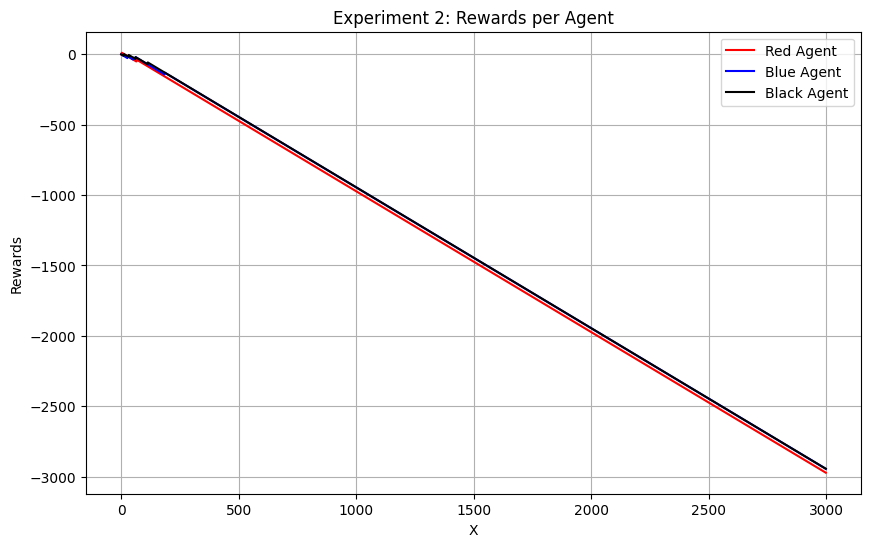

In [106]:
# Experiment 2 - Environment parameters
environment_rows = 5
environment_cols = 5
num_actions = 6
learning_rate = 0.3
discount_factor = 0.5

# Initialize agents with Q-tables
redAgent2 = Agent(0)
redAgent2.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blueAgent2 = Agent(1)
blueAgent2.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blackAgent2 = Agent(2)
blackAgent2.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

# Run exploit policy for 9000 steps
currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit9000 = int(9000/3)
policy = "PEXPLOIT"
for i in range(exploit9000):
    currEnvironment = redAgent2.stepS(currEnvironment, policy)
    currEnvironment = blueAgent2.stepS(currEnvironment, policy)
    currEnvironment = blackAgent2.stepS(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the exploit run
print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent2.getReward()}")
print(f"Blue Reward: {blueAgent2.getReward()}")
print(f"Black Reward: {blackAgent2.getReward()}")

# Display Q-tables for each agent
print("\nRed Agent QTable")
redAgent2.qtable.print_q_table()
print("\nBlue Agent QTable")
blueAgent2.qtable.print_q_table()
print("\nBlack Agent QTable")
blackAgent2.qtable.print_q_table()

# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent2.getRewardList(), color='red', label='Red Agent')
plt.plot(blueAgent2.getRewardList(), color='blue', label='Blue Agent')
plt.plot(blackAgent2.getRewardList(), color='black', label='Black Agent')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Rewards')
plt.title('Experiment 2: Rewards per Agent')
plt.legend()
plt.grid(True)
plt.show()


##### Experiment 3:

In Experiment 3 we rerun Experiment 1.c but this time with two different learning rates: a1=0.15 and a2=0.45


Exploit Run (Learning rate 0.15): [1, 4, 2, 5, 2, 3, 1, 0, 0, 5, 2, 5, 0, 0, 2]
Red Reward: -2763
Blue Reward: -2721
Black Reward: -2665

Red Agent QTable - Learning Rate 0.15
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00   0.00   0.00  -0.15   0.00
(0,1)   |    0.00   0.00   0.00   0.00  -0.15  -0.15
(0,2)   |    0.00   0.00  -0.28   0.00  -0.39  -0.15
(0,3)   |    1.95   0.00  -0.15  -0.15  -0.28  -0.28
(0,4)   |    0.00   0.00  -0.29  -0.28  -0.39   0.00
(1,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,2)   |    0.00   0.00  -0.15   0.00  -0.28   0.00
(1,3)   |    0.00   0.00   0.00   0.00  -0.15  -0.15
(1,4)   |    0.00   0.00  -0.15  -0.15  -0.28   0.00
(2,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,2)   |    0.00   0.00   0.00   0.00  -0.15   0.00
(2,3)   |    0.00 

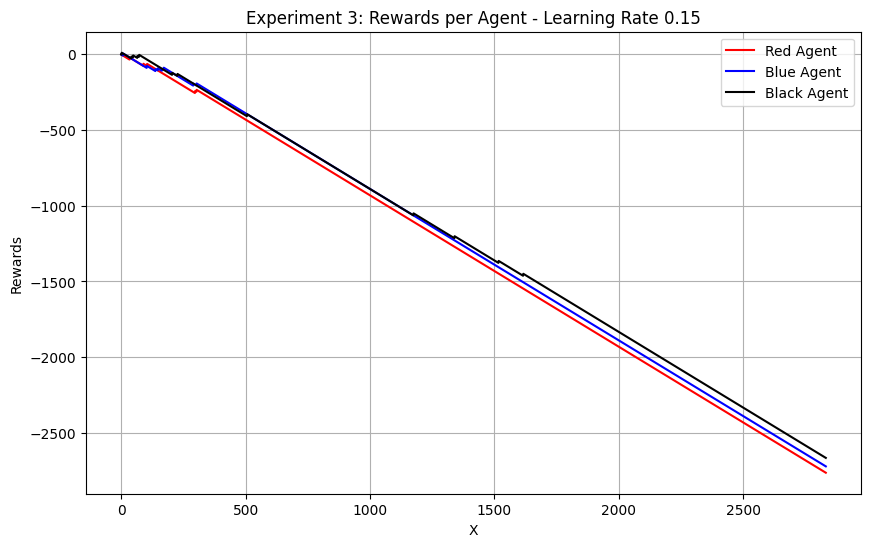


Exploit Run (Learning rate 0.45): [1, 2, 1, 5, 2, 4, 0, 0, 0, 5, 1, 4, 0, 0, 5]
Red Reward: -2777
Blue Reward: -2749
Black Reward: -2693

Red Agent QTable - Learning Rate 0.45
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.45   0.00  -0.45  -0.70
(0,1)   |    0.00   0.00  -0.45  -0.45  -0.70  -0.70
(0,2)   |    0.00   0.00  -0.70  -0.45  -0.83  -0.70
(0,3)   |    5.85   0.00  -0.93  -0.80  -0.99  -1.15
(0,4)   |    0.00   0.00  -0.70  -0.70  -0.91   0.00
(1,0)   |    0.00   5.85   0.00   0.00   0.00  -0.45
(1,1)   |    0.00   0.00   0.00   0.00  -0.45  -0.45
(1,2)   |    0.00   0.00  -0.45   0.00  -0.70  -0.45
(1,3)   |    0.00   0.00  -0.70  -0.45  -0.70  -1.08
(1,4)   |    0.00   0.00  -0.45  -0.45  -0.83   0.00
(2,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,2)   |    0.00   0.00   0.00   0.00  -0.45   0.00
(2,3)   |    0.00 

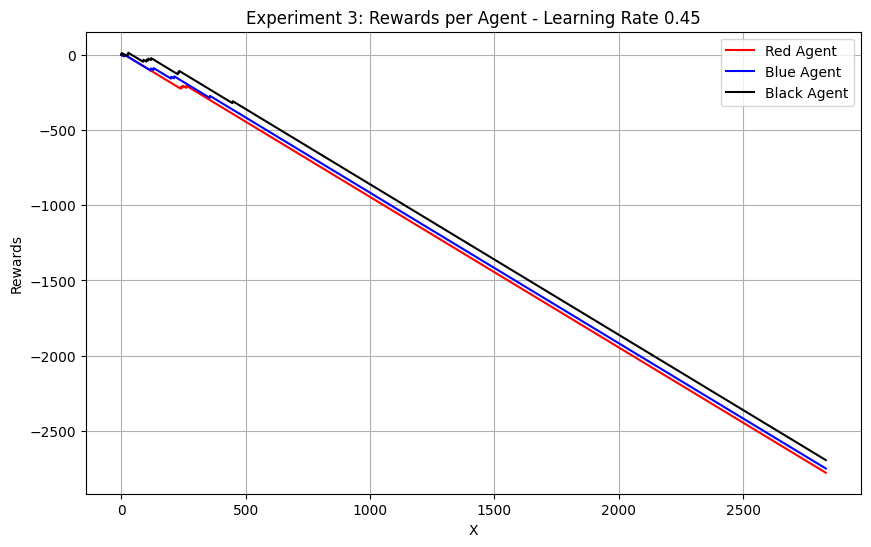

In [108]:
# Experiment 3 - Environment parameters
environment_rows = 5
environment_cols = 5
num_actions = 6

# Learning rates
a1 = 0.15        
a2 = 0.45         

discount_factor = 0.5

# Initialize agents with different learning rates
redAgent3a1 = Agent(0)
redAgent3a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

blueAgent3a1 = Agent(1)
blueAgent3a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

blackAgent3a1 = Agent(2)
blackAgent3a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

# Run exploit policy for learning rate 0.15
currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent3a1.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent3a1.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent3a1.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the exploit run with learning rate 0.15
print(f"\nExploit Run (Learning rate 0.15): {currEnvironment}")
print(f"Red Reward: {redAgent3a1.getReward()}")
print(f"Blue Reward: {blueAgent3a1.getReward()}")
print(f"Black Reward: {blackAgent3a1.getReward()}")

# Display Q-tables for each agent with learning rate 0.15
print("\nRed Agent QTable - Learning Rate 0.15")
redAgent3a1.qtable.print_q_table()
print("\nBlue Agent QTable - Learning Rate 0.15")
blueAgent3a1.qtable.print_q_table()
print("\nBlack Agent QTable - Learning Rate 0.15")
blackAgent3a1.qtable.print_q_table()

# Plot rewards for learning rate 0.15
plt.figure(figsize=(10, 6))
plt.plot(redAgent3a1.getRewardList(), color='red', label='Red Agent')
plt.plot(blueAgent3a1.getRewardList(), color='blue', label='Blue Agent')
plt.plot(blackAgent3a1.getRewardList(), color='black', label='Black Agent')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Rewards')
plt.title('Experiment 3: Rewards per Agent - Learning Rate 0.15')
plt.legend()
plt.grid(True)
plt.show()


# Initialize agents with learning rate 0.45
redAgent3a2 = Agent(0)
redAgent3a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

blueAgent3a2 = Agent(1)
blueAgent3a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

blackAgent3a2 = Agent(2)
blackAgent3a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

# Run exploit policy for learning rate 0.45
currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent3a2.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent3a2.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent3a2.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

# Display results for the exploit run with learning rate 0.45
print(f"\nExploit Run (Learning rate 0.45): {currEnvironment}")
print(f"Red Reward: {redAgent3a2.getReward()}")
print(f"Blue Reward: {blueAgent3a2.getReward()}")
print(f"Black Reward: {blackAgent3a2.getReward()}")

# Display Q-tables for each agent with learning rate 0.45
print("\nRed Agent QTable - Learning Rate 0.45")
blackAgent3a2.qtable.print_q_table()
print("\nBlue Agent QTable - Learning Rate 0.45")
blackAgent3a2.qtable.print_q_table()
print("\nBlack Agent QTable - Learning Rate 0.45")
blackAgent3a2.qtable.print_q_table()

# Plot rewards for learning rate 0.45
plt.figure(figsize=(10, 6))
plt.plot(redAgent3a2.getRewardList(), color='red', label='Red Agent')
plt.plot(blueAgent3a2.getRewardList(), color='blue', label='Blue Agent')
plt.plot(blackAgent3a2.getRewardList(), color='black', label='Black Agent')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Rewards')
plt.title('Experiment 3: Rewards per Agent - Learning Rate 0.45')
plt.legend()
plt.grid(True)
plt.show()


##### Experiment 4: 

In Experiment 4 we rerun Experiment 1c only that this time we run PRANDOM for the first 500 steps; next, we run PEXPLOIT; however, after a terminal state is reached the third time, we change the three pickup locations to: (4,2), (3,3) and (2,4); the drop off locations and the Q-table remain unchanged; finally, we continue running PEXPLOIT with the “new” pickup locations until the agent reaches a terminal state the sixth time.


Exploit Run: [1, 4, 1, 1, 2, 5, 0, 1, 0, 5, 5, 3, 1, 0, 0]
Red Reward: -5454
Blue Reward: -5384
Black Reward: -5566

Red Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.66   0.00  -0.76  -0.76
(0,1)   |    0.00   0.00  -0.79  -0.87  -0.92  -0.87
(0,2)   |    0.00   0.00  -0.77  -1.18  -0.93  -1.18
(0,3)   |    3.85   0.00  -0.73  -1.04  -0.84  -0.55
(0,4)   |    0.00   0.00  -0.66  -0.76  -0.76   0.00
(1,0)   |    0.00   3.90  -0.51   0.00  -0.66  -0.66
(1,1)   |    0.00   0.00  -0.55  -0.70  -0.77  -0.70
(1,2)   |    3.85   0.00  -0.55  -1.14  -0.77  -1.13
(1,3)   |    0.00   0.00  -0.51  -0.99  -0.71  -0.30
(1,4)   |    0.00   0.00  -0.51  -0.66  -0.66   0.00
(2,0)   |    0.00   0.00  -0.30   0.00  -0.51  -0.51
(2,1)   |    6.53   0.00  -0.30  -0.51  -0.61  -0.51
(2,2)   |    0.00   0.00  -0.30  -1.14  -0.61  -1.12
(2,3)   |    0.00   0.00  -0.30  -0.98  -0.59   0.00
(2,4)  

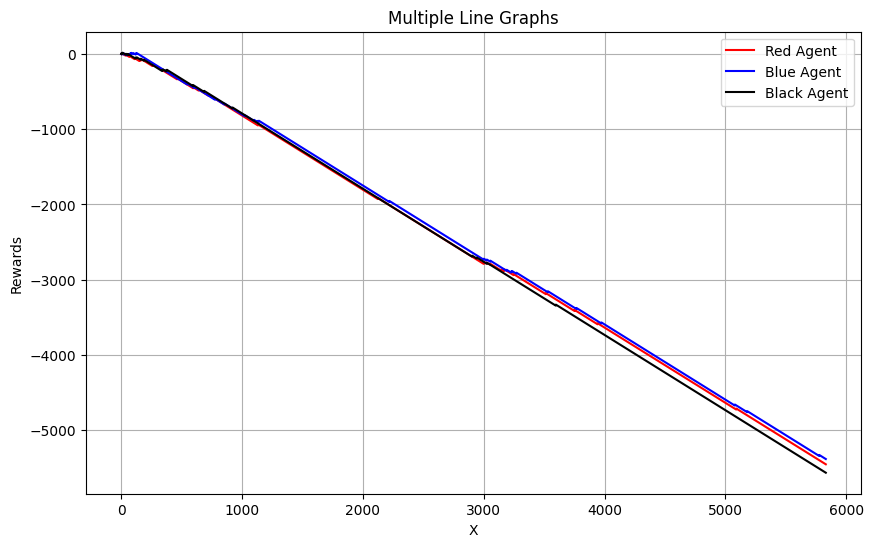

In [10]:
# Experiment 4
environment_rows=5
environment_cols=5
num_actions = 6
learning_rate = 0.3
discount_factor = 0.5

redAgent4 = Agent(0)
redAgent4.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blueAgent4 = Agent(1)
blueAgent4.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blackAgent4 = Agent(2)
blackAgent4.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
random500 = int(500/3)
policy = "PRANDOM"
for i in range(random500):
    currEnvironment = redAgent4.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent4.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent4.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
finishCount = 0
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent4.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent4.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent4.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        finishCount += 1
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
        if(finishCount == 3):
            break

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
finishCount = 0
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent4.stepQ4(currEnvironment, policy)
    currEnvironment = blueAgent4.stepQ4(currEnvironment, policy)
    currEnvironment = blackAgent4.stepQ4(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        finishCount += 1
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
        if(finishCount == 3):
            break

print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent4.getReward()}")
print(f"Blue Reward: {blueAgent4.getReward()}")
print(f"Black Reward: {blackAgent4.getReward()}")

# Display Q-tables for each agent
print("\nRed Agent QTable")
redAgent4.qtable.print_q_table()
print("\nBlue Agent QTable")
blueAgent4.qtable.print_q_table()
print("\nBlack Agent QTable")
blackAgent4.qtable.print_q_table()

# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent4.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent4.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent4.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title
plt.legend()
plt.grid(True)
plt.show()